# SHG imaging of LC samples using plane wave illumination - 1D 4x4 matrix method

Here, we use a 1D simulator on a 3D LC sample illuminated with a single plane wave - no diffraction effects. For this to be valid, the sample thickness has to be small compared to the lateral variation of the LC director in the plane of the cell.

We assume that the structure is 1D, and it may change radically along the propagation direction (valid for cholesterics). Layer thickness has to be set at about 1/10 of the wavelength. Otherwise, the calculation of the SHG will not be accurate (we see this as a violation of energy conservation of the solution). The method uses 4x4 matrix formalism, and we compute both the forward propagating field and the reflected and backward propagating wave. After the computation, we perform an energy conservation check to see if the algorithm has converged.


The algorithm first obtains the fundamental beam E field inside the structure. Then, it computes the perturbation of the effective refractive index change caused by the fundamental beam, which induces the SHG field and propagates the SHG field through the sample. If the intensity of the fundamental beam is expected to deplete during SHG conversion, you need to perform multiple SHG computation runs so that we converge to a valid solution.
We have three types of calculations here. One is a multi-wavelength calculation, where one selects a single (x,y) coordinate in the sample and computes SHG for several wavelengths. In another run, we must fix the wavelength and perform multi-pixel calculation. Finally, you can perform a full computation. In this case, you need to limit the range of wavelengths and the domain size so that the problem can fit into the system memory.




# Configuration
## Imports and non-settable constants

In [2]:
# dtmm configuration 
import dtmm2.conf
from dtmm2.conf import CDTYPE, FDTYPE

# core TMM functions for 1D calculation using plane waves
from dtmm2.tmm import alphaffi, alphaf, fvec2hevec, phase_mat,hzez_mat, beam_eig, \
             transfer_beam, hevec, beam_transfer_mat, layer_mat,transfer_mat, avec, \
            avec2fvec, field_mat, system_mat, reflection_mat, reflect,  avec2fvec, poynting, fvec2avec, project

from dtmm2 import tmm

# sorce (beam) creation functions
from dtmm2.source import scalar_field, vector_field

# extended TMM matrices for beam propagation
from dtmm2.matrix import mode_diffraction_mat, mode_cover_mat, mode_refraction_mat,  apply_mode_matrix, mode_hzez_mat
from dtmm2.matrix import field_diffraction_mat,  field_cover_mat, field_refraction_mat,  apply_field_matrix, field_transmittance_mat

# operators for beams
from dtmm2.operator import lens_transform, focal_pixelsize

# some conversion functions
from dtmm2.data import matrix2tensor, eps2epsva, chi2array

# scalar waves and helper functions
from dtmm2.wave import betaphi, eigenmask, k0, planewave, wave2eigenwave

# general 4x4 and 2x2 linear algebra (matrix and vector dot functions)
from dtmm2.linalg import multi_dot, dotmv, dotmf, eig, dotmm, dotchi2v, inv, dotmf

# functions for vector/tensor rotation matrix creation and rotations
from dtmm2.rotation import rotation_matrix, rotate_vector, rotate_diagonal_tensor, rotate_tensor

# 2D field creation and conversion functions
from dtmm2.field import field2modes, modes2field, field2intensity, field2poynting, field2fvec, fvec2field

# fft functions
from dtmm2.fft import fft2, ifft2

# progress bar printing
from dtmm2.print_tools import print_progress

# non-dtmm2 stuff
import matplotlib.pyplot as plt
import numpy as np


def set_analysis_mode(mode):
    """Sets analysis mode. Either: 
         'image' : for image analysis at single wavelength, 
         'wavelength' :  for wavelength analysis at single pixel
         'full' : both image and wavelengths analysis'
         """
    global MODE
    if mode.lower() in ('image', 'full', 'wavelength'):
        MODE = mode
    else:
        raise ValueError('Invalid analysis mode')
        
def polstr(pol):
    """Returns string representation of the polarization state"""
    x,y = pol
    return '({:.2f},{:.2f})'.format(x,y)
    
# To convert from intensity to internal unitless E field representation, we must normalize with impedance of free space and multiply by 2.
# The factor 2 is needed because of the current implementation of the poynting() function in dtmm, which omits 0.5 term in ExH product.
# This assures proper creation of the input field amplitude from the requestet intensity in SI units.
Z0 = 376.73 * 2

## Experimental parameters

The main experimental parameters are set here. We use CAPITALCASE for all constants that are meant to be set only once.
Any change of constants defined here requires a complete computation re-run.

Our sample is a uniaxial LC material (we can also work with biaxial) placed between two identical glass plates. Dimensions of the sample are set in microns. Wave intensity (power flux) is set in W/m$^2$ and the $\chi^{(2)}$ tensor is defined using the nonlinear tensor coefficients $d_{i,j}$ in SI units of [m/V]. Note that due to the convension $\chi^{(2)}_{i,j}  = 2*d_{i,j}$. Care must be taken when creating the $\chi^{(2)}$ tensor array, as the algorithm does not prevent you to calculate with a non-symmetric tensor. We use the `chi2array` function to construct a valid nonlinear susceptibility tensor. This function inspectes the validity of the input coefficients and constructs a valid symmetric tensor.

The $j$ coefficient stands for $j=1\rightarrow 1,1$, $j=2 \rightarrow 2,2$, $j=3 \rightarrow 3,3$, $j=4 \rightarrow 2,3 = 3,2$, $j=5 \rightarrow  1,3 = 3,1$, $j=6 \rightarrow  1,2 = 2,1$.

In the configuration step, we first define the computation domain size. Then we define the material dispersion and the director profile.

### Light source

### Computational domain and core parameters

Core parameters are here. Please inpect the prints to find possible errors and to inspect whether the model will fit into the memory or not

In [3]:
# User constants and configuraion
# ///////////////////////////////
set_analysis_mode('image') #'image' , 'wavelength' or 'full'

dtmm2.conf.set_verbose(2) # for progress bar
# data sampling shape, choose wisely

SHAPE = (100,20,20) # data shape (n layers, n pixels height, n pixels width)
# which polarization states of input light we compute for.
POLARIZATIONS = [(np.cos(p), np.sin(p)) for p in [0, np.pi/2]]
# wavelength used for single-wavelength calculation
WAVELENGTH = 800
# intensity used for single-wavelength calculation
INTENSITY = 1e6
# wave propagation parameter for single-wavelength calculation
BETA = 0 # see dtmm documentation on this, the beta parameter n*sin(theta)
# The phi angle of the wave, only matters if BETA != 0
PHI = 0 
# wavelength range for the multi-wavelength calculation
WAVELENGTHS = np.linspace(1200,1800,30) # nm
# wave intensity for each of the waves of the multi-wavelength calculation.
INTENSITIES = [INTENSITY]*len(WAVELENGTHS)
# wave beta parameter for each of the waves of the multi-wavelength calculation.
BETAS = [BETA]*len(WAVELENGTHS) 
# wave phi parameter for each of the waves of the multi-wavelength calculation.
PHIS = [PHI]*len(WAVELENGTHS) 

D33 = 5.6e-12

# the chi2 tensor 
CHI2 = chi2array(d33 = D33, d13 = 0)
# sample thickness
THICKNESS = 5. # microns
# imaged region 
WIDTH = 100. # microns
HEIGHT = 100. # microns


# cover/substrate glass refractive index
NCOVER = 1.75

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# STOP! Computed constants, Do not set manually!
# //////////////////////////////////////////////

STEPSIZE = THICKNESS/SHAPE[0]*1000 #nm
# unitless wave number of fundamental and shg waves. Do not set manually!
K01 = 2*np.pi/WAVELENGTH * STEPSIZE
# SHG wave
K02 = 2* K01

K01S = 2*np.pi/WAVELENGTHS * STEPSIZE
# SHG wave
K02S = 2* K01S

# epsilon and euler angles for the cover glass
EPSILON0 = np.ones((3,)) * NCOVER **2
ANGLES0 = np.zeros((3,)) 

# matrices size in MB for single-wavelength run
MB_WAVELENGTH = 2* SHAPE[0]*SHAPE[1]*SHAPE[2]*4*4/1024/1024 * np.dtype(CDTYPE).itemsize 
# matrices size in MB for single-pixel run
MB_PIXEL = 2* len(WAVELENGTHS) * SHAPE[0]*4*4/1024/1024 * np.dtype(CDTYPE).itemsize 
# required memroy size for full computation
GB_FULL = 2*len(WAVELENGTHS)* SHAPE[0]*SHAPE[1]*SHAPE[2]*4*4/1024/1024/1024 * np.dtype(CDTYPE).itemsize 

# matrices size in MB for single-wavelength run
MB_WAVELENGTH_F = len(POLARIZATIONS)*MB_WAVELENGTH//SHAPE[0]
# matrices size in MB for single-pixel run
MB_PIXEL_F = len(POLARIZATIONS)*MB_PIXEL//SHAPE[0]
# required memroy size for full computation
GB_FULL_F = len(POLARIZATIONS)*GB_FULL//SHAPE[0]

def print_model_info():
    print("Domain size:")
    print(f'  {len(WAVELENGTHS)} x {SHAPE}')
    print()
    print('Approximate matrices memory:')
    print(' Single-wavelength : {:.1f} MB'.format(MB_WAVELENGTH))
    print(' Single-pixel      : {:.1f} MB'.format(MB_PIXEL))
    print(' Full computation  : {:.2f} GB'.format(GB_FULL))
    print()
    print('Approximate fields memory:')
    print(' Single-wavelength : {:.1f} MB'.format(MB_WAVELENGTH_F))
    print(' Single-pixel      : {:.1f} MB'.format(MB_PIXEL_F))
    print(' Full computation  : {:.2f} GB'.format(GB_FULL_F))
    print()
    print('Sample parameters:')
    print(f' Cover glass: n = {NCOVER}')
    print(f' Sample thickness: {THICKNESS} um')
    print(f' Sample width: {WIDTH} um')
    print(f' Sample height: {HEIGHT} um')
    print()
    print('Chi2 tensor [m/V]:')
    print(CHI2)
    print()
    print('Multi-wavelength parameters')
    print(' Wavelength range : {:.1f} - {:.1f} nm'.format(min(WAVELENGTHS), max(WAVELENGTHS)))
    print(' Intensity range  : {:.1f} - {:.1f} W/m2'.format(min(INTENSITIES), max(INTENSITIES)))
    print(' Number of waves  : {}'.format(len(WAVELENGTHS)))
    print()
    print('Single-wavelength parameters')
    print(f' Wavelength : {WAVELENGTH} nm' )
    print(f' Intensity  : {INTENSITY} W/m2' )
    print()
    print('Polarizations')
    print(POLARIZATIONS)
    print()
    print('Calculation parameters')
    print(f' Step size: {STEPSIZE} nm')


print_model_info()


Domain size:
  30 x (100, 20, 20)

Approximate matrices memory:
 Single-wavelength : 19.5 MB
 Single-pixel      : 1.5 MB
 Full computation  : 0.57 GB

Approximate fields memory:
 Single-wavelength : 0.0 MB
 Single-pixel      : 0.0 MB
 Full computation  : 0.00 GB

Sample parameters:
 Cover glass: n = 1.75
 Sample thickness: 5.0 um
 Sample width: 100.0 um
 Sample height: 100.0 um

Chi2 tensor [m/V]:
[[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 1.12e-11 0.00e+00 0.00e+00 0.00e+00]]

Multi-wavelength parameters
 Wavelength range : 1200.0 - 1800.0 nm
 Intensity range  : 1000000.0 - 1000000.0 W/m2
 Number of waves  : 30

Single-wavelength parameters
 Wavelength : 800 nm
 Intensity  : 1000000.0 W/m2

Polarizations
[(1.0, 0.0), (6.123233995736766e-17, 1.0)]

Calculation parameters
 Step size: 50.0 nm


### Refractive index dispersion

We define the dispersion of the ordinary and extraordinary refractive indices as a function and plot the fundamental and SHG wave refractive indices. Note that we define no and ne and then map these to n1, n2 and n3. This is because the algorithm also works for biaxial case and therefore expects functions n1,n2,n3 as input.

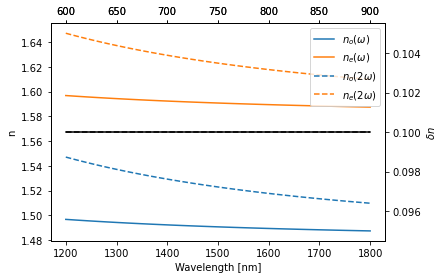

In [4]:
def ne(wavelength):
    return 1.8447 + 24151/(wavelength**2)

def no(wavelength):
    return 1.6347 + 24151/(wavelength**2)

def ne(wavelength):
    return 1.58 + 24151/(wavelength**2)

def no(wavelength):
    return 1.48 + 24151/(wavelength**2)
    
# we actualy use n1, n2, n3 functions, so we need to map no and ne
n1 = no 
n2 = no 
n3 = ne 

# plot for visual inspection

fix, ax1 = plt.subplots(1)
axd1 = ax1.twinx()

plt.ylabel(r'$\delta n$')
ax2 = ax1.twiny()
axd2 = axd1.twiny()

l1 = ax1.plot(WAVELENGTHS, no(WAVELENGTHS), label = '$n_o(\omega)$')
l2 = ax1.plot(WAVELENGTHS, ne(WAVELENGTHS), label = '$n_e(\omega)$')

ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('n')

axd1.plot(WAVELENGTHS, ne(WAVELENGTHS) - no(WAVELENGTHS), 'k', label =r'$\delta n$')

l3 = ax2.plot(WAVELENGTHS/2, no(WAVELENGTHS/2), '--', label = '$n_o(2\omega)$')
l4 = ax2.plot(WAVELENGTHS/2, ne(WAVELENGTHS/2), '--',label = '$n_e(2\omega)$')

axd2.plot(WAVELENGTHS/2, ne(WAVELENGTHS/2) - no(WAVELENGTHS/2), 'k--')


ls = l1 + l2 + l3 + l4
lbls = [l.get_label() for l in ls]
plt.legend(ls, lbls)
plt.show()


### Director orientation

Here we define the three Euler angles $\psi,\theta,\phi$ as parametric functions that define the orientation of the eigenframe in the given voxel defined by a coordinate (x,y,z). The functions take a numpy array coordinates x,y,z and must return a new array of same shape and type. Then the program automatically build the required material Euler angles array used for calculation. 

We also define the three angles for a single-pixel run.

In case of uniaxial LC, you must set the $\theta$ and $\phi$ angles which correspond to the orientation of the director with respect to the laboratory coordinate frame. $\theta = 0$ is along the $z$ axis, $\theta = pi/2$ and $\phi=0$ is along the $x$ axis. 



Single-wave parameters
 Psi range:   0.000 - 0.000 rad
 Theta range: 0.000 - 1.571 rad
 Phi range:   0.000 - 1.571 rad

Multi-wavelength parameters
 Psi range:   0.000 - 0.000 rad
 Theta range: 1.571 - 1.571 rad
 Phi range:   0.000 - 0.000 rad
 I index : 0
 J index : 0


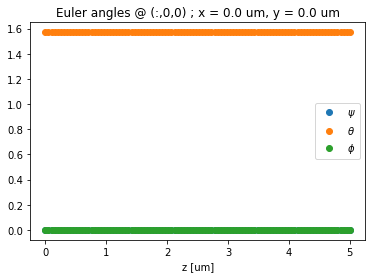

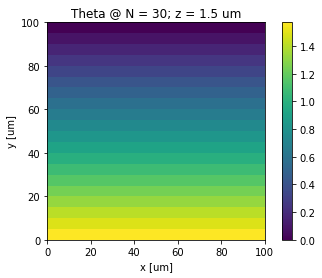

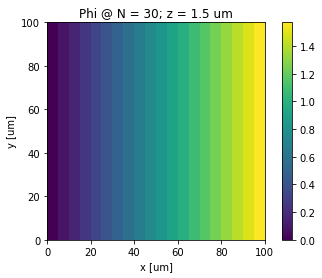

In [5]:
I = 0 # height index for single-pixel run
J = 0 # width index for single-pixel run

N = 30 # layer index for plotting

ROTATION = np.pi/2 # max rotation of the director along x
TILT = np.pi/2 # max tilt angle of the director along y

def psi(x,y,z):
    return 0. # For uniaxial set to zero or any value
    
def theta(x,y,z):
    return TILT - y/HEIGHT * TILT

def phi(x,y,z):
    return  x/WIDTH * ROTATION

# computed parameters. Do not change these!
#//////////////////////////////////////////

# range of coordinates in z,y, and x directions
z = np.linspace(0,THICKNESS, SHAPE[0])
y = np.linspace(0,HEIGHT, SHAPE[1])
x = np.linspace(0,WIDTH, SHAPE[2])

# we use ij indexing in dtmm, the first axis is (i = z), then height (j = y), then width (k = x)
zzz,yyy,xxx = np.meshgrid(z,y,x, indexing = 'ij')

# create an empty placehold of floats
ANGLES = np.empty(SHAPE+(3,), dtype = FDTYPE)
# fill the array
ANGLES[...,0] = psi(xxx,yyy,zzz)
ANGLES[...,1] = theta(xxx,yyy,zzz)
ANGLES[...,2] = phi(xxx,yyy,zzz)

def print_director_info():
    print('Single-wave parameters')
    print(' Psi range:   {:.3f} - {:.3f} rad'.format(ANGLES[...,0].min(), ANGLES[...,0].max()))
    print(' Theta range: {:.3f} - {:.3f} rad'.format(ANGLES[...,1].min(), ANGLES[...,1].max()))
    print(' Phi range:   {:.3f} - {:.3f} rad'.format(ANGLES[...,2].min(), ANGLES[...,2].max()))
    print()
    print('Multi-wavelength parameters')
    print(' Psi range:   {:.3f} - {:.3f} rad'.format(ANGLES[...,I,J,0].min(), ANGLES[...,I,J,0].max()))
    print(' Theta range: {:.3f} - {:.3f} rad'.format(ANGLES[...,I,J,1].min(), ANGLES[...,I,J,1].max()))
    print(' Phi range:   {:.3f} - {:.3f} rad'.format(ANGLES[...,I,J,2].min(), ANGLES[...,I,J,2].max()))
    print(f' I index : {I}' )
    print(f' J index : {J}' )
    
print_director_info()

# We plot angles with modulo 2 pi 
pi2 = 2*np.pi

fig = plt.figure()
plt.plot(z, ANGLES[:,I,J,0]%pi2,'o',label = r'$\psi$')
plt.plot(z, ANGLES[:,I,J,1]%pi2,'o',label = r'$\theta$')
plt.plot(z, ANGLES[:,I,J,2]%pi2,'o',label = r'$\phi$')
plt.xlabel('z [um]')
plt.title(r'Euler angles @ (:,{},{}) ; x = {:.1f} um, y = {:.1f} um'.format(I,J,xxx[N,I,J], yyy[N,I,J]))
plt.legend()

fig = plt.figure()
im1 = plt.imshow(ANGLES[N,:,:,1]%pi2, origin = 'lower', extent = (0,HEIGHT, 0, WIDTH))
plt.title(r'Theta @ N = {}; z = {:.1f} um'.format(N, z[N]))
fig.colorbar(im1)
plt.xlabel('x [um]')
plt.ylabel('y [um]')

fig = plt.figure()
im2 = plt.imshow(ANGLES[N,:,:,2]%pi2, origin = 'lower', extent = (0,HEIGHT, 0, WIDTH))
plt.xlabel('x [um]')
plt.ylabel('y [um]')
plt.title(r'Phi @ N = {}; z = {:.1f} um'.format(N, z[N]))
fig.colorbar(im2)

### Light source

Here we build and inspect the fundamental beam source used later for beam-scanning imaging. The goal here is to simulate the EH field at the entrance of the sample.

We assume that the beam is first shaped and defined in the infinity space, where we may work with paraxial beams. We define the amplitude (gaussian beam), define the polarization of the beam, and finally, project the beam using an idealized infinity corrected imaging system sonsisting of a tube lens and an objective lens. Together they form an imaging system that transfers the input plane of beam to the sample plane with a given magnification/compression.

We assume that the objective (lens) used to compress the beam uses standard 0,17 cover glass correction and we define the extra glass thickness over which the beam travels prior to reaching the sample. We also define the focal plane of the beam and inspect its profile as it travels through the glass so that we can astimate the true focal plane in the sample. 

8.0
Computing eigensystem


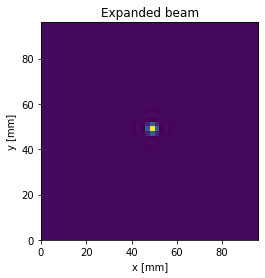

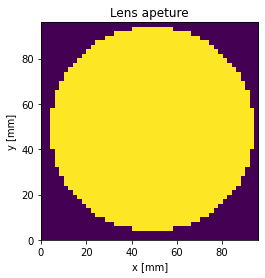

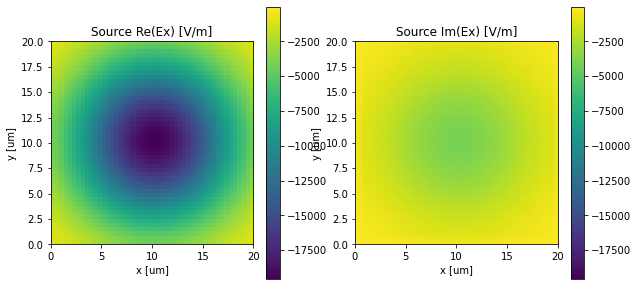

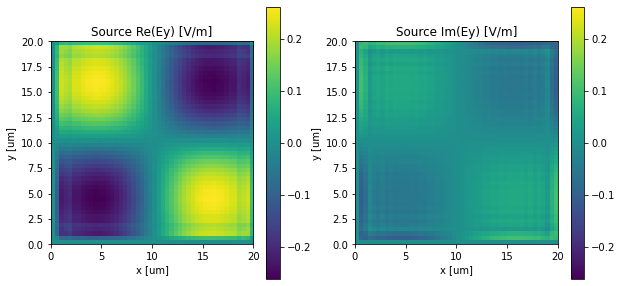

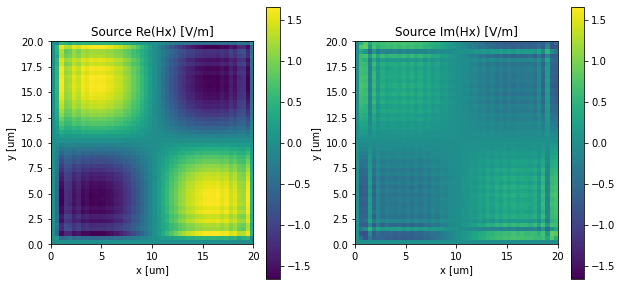

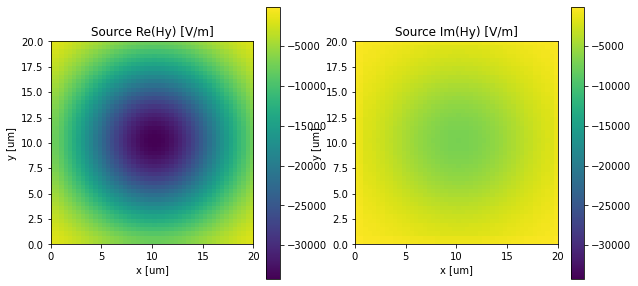

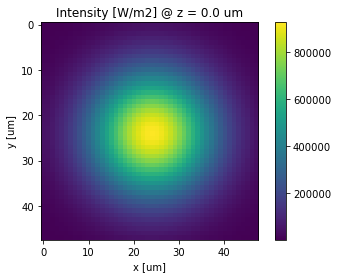

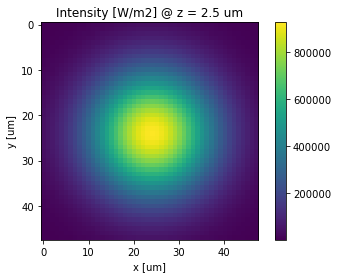

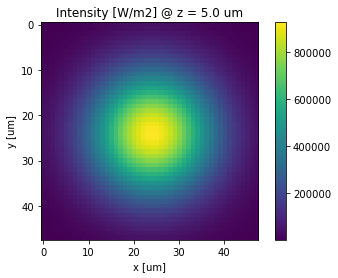

In [194]:
# lens focal length used to compress the beam to the requested shape
LENS_FOCAL = 50 # mm
# Numerical aperture of the lens
LENS_NA = 0.9
# defines the beam domain size in microns. Should be much larger than beam waist size.
BEAM_HEIGHT = 20. # um
BEAM_WIDTH = 20. # um

#requested gaussian beam waist in microns
WAIST = 8. # um
# does not really matter, we will work on 1D sample, position of the beam does not matter. Just for visualization.
CENTER = (BEAM_HEIGHT/2.,BEAM_WIDTH/2.)
#CENTER = (0,0)

# shape of the array representation of the beam. Together with wavlength, and pixel size parameters
# it defines the resolution of the beam.
BEAM_SHAPE = (48,48)

# where to put beam waist, assuming propagation is in a medium with refractive index of NCOVER
FOCAL = -THICKNESS/2 

DCOVER = 0.17 # actual cover glass thickness.
DLENS = 0.17 # objective lens cover glass correction thikcness


#STOP! computed parameters bellow
#////////////////////////////////



def window(x,y):
    print(WAIST)
    return np.exp(-((x-CENTER[0])**2+(y-CENTER[1])**2)/WAIST**2)
   
o0 = BEAM_HEIGHT/BEAM_SHAPE[0]/2
o1 = BEAM_WIDTH/BEAM_SHAPE[1]/2 
yw = np.linspace(o0,BEAM_HEIGHT-o0, BEAM_SHAPE[0])
xw = np.linspace(o1,BEAM_WIDTH-o1, BEAM_SHAPE[1])
CENTER = (BEAM_HEIGHT/2. + o0,BEAM_WIDTH/2. + o1)

#we use ij indexing in dtmm, the first axis is (i = z), then height (j = y), then width (k = x)
yy,xx = np.meshgrid(yw,xw, indexing = 'ij')

# gaussian window function. We will use it to constuct the beam
WINDOW = window(xx,yy)
#WINDOW += np.random.randn(*BEAM_SHAPE)

# pixel aspect ratio. We can have different resolutions in x and y.
# normally, we will use square view and aspect ratio is then 1.
PIXEL_ASPECT = BEAM_WIDTH/BEAM_SHAPE[1]/(BEAM_HEIGHT/BEAM_SHAPE[0])

# computed! defines the size of the pixel for the array representation of the beam.
PIXEL_SIZE = BEAM_HEIGHT/BEAM_SHAPE[0] * 1000 # nm

# uncomepnsated cover glass thickness
DCOMP = (DCOVER-DLENS)*1e6/ PIXEL_SIZE  #in pixel units

# computed unitless wavenumber
K01_PIXEL = k0(WAVELENGTH, PIXEL_SIZE)
K02_PIXEL = k0(WAVELENGTH/2, PIXEL_SIZE)
K01_PIXEL2 = k0(WAVELENGTH, PIXEL_SIZE*1000)

#first create a scalar eigenwave. Only needed if BETA != 0., otherwise it is unity.
wave = planewave(BEAM_SHAPE , K01_PIXEL, BETA , PHI, aspect = 1.)
# this function converts the wave to a nearest eigenwave
wave = wave2eigenwave(wave) 
# apply the amplitude function
wave = wave * WINDOW * (INTENSITY * Z0)**0.5

DPIXEL = STEPSIZE/PIXEL_SIZE 



# create light source placehold
# source is of shape (2,4,N,M) representing a field array of the beam in real space
source1 = np.zeros((2,4,) + BEAM_SHAPE, dtype = CDTYPE)
source2 = np.zeros((2,4,) + BEAM_SHAPE, dtype = CDTYPE)

for i, jones in enumerate(POLARIZATIONS):
    source1[i] = scalar_field(wave, jones, epsilon = (1,1,1))

#now define the mode indices that we will use to represent our field 
mode_mask1 = eigenmask(BEAM_SHAPE, K01_PIXEL, aspect = PIXEL_ASPECT, betamax = 0.9)
mode_mask2 = eigenmask(BEAM_SHAPE, K02_PIXEL, aspect = PIXEL_ASPECT, betamax = 0.9)

p, a = focal_pixelsize(BEAM_SHAPE, K01_PIXEL,  aspect = 1., focal = 50)
extent_beam = [0, p*BEAM_SHAPE[0]/1e6,0,p*BEAM_SHAPE[1]/1e6] # mm

fsource1 = np.fft.fftshift(ifft2(np.fft.ifftshift(source1, axes = (-2,-1))),axes = (-2,-1))
norm = (BEAM_SHAPE[0] * BEAM_SHAPE[1])**0.5
fsource1 *= norm


#source1 = vector_field(source1,K01_PIXEL,epsilon = (1,1,1), mask = mode_mask1)

#refmat = field_refraction_mat(BEAM_SHAPE, K01_PIXEL, epsilon = (NCOVER**2, NCOVER**2, NCOVER**2+0.00001),angles = (0,0,0), mask = mode_mask1)
#source1 = lens_transform(fsource1, refmat)

cmat = field_cover_mat(BEAM_SHAPE, K01_PIXEL, d_cover = DCOMP, n_cover = NCOVER, mask = mode_mask1)
tmat = field_transmittance_mat(BEAM_SHAPE, K01_PIXEL, epsilon2 = (NCOVER**2,NCOVER**2,NCOVER**2))
mat = dotmm(tmat,cmat)
mat = tmat
source1 = apply_field_matrix(source1, mat)


# this function returns mode_mask and actual mode coefficients
# we have devined mode mask above, so no need to track
_, modes1 = field2modes(source1, K01_PIXEL, mask = mode_mask1)
_, modes2 = field2modes(source2, K02_PIXEL, mask = mode_mask2)

    
print("Computing eigensystem")
alpha1, fmat1 = beam_eig(K01_PIXEL,EPSILON0,ANGLES0,mask = mode_mask1) 
fmati1 = inv(fmat1)

#alpha0, fmat0 = beam_eig(K01_PIXEL2,EPSILON0,ANGLES0,mask = mode_mask1) 
#fmati0 = inv(fmat0)

#modes1 = dotmv(fmat1,dotmv(fmati0,modes1))

# backpropate so that we have slightly defocused beam at the entrance surface
# this way  the beam will get in focal point at the middle of the sample
pmat = phase_mat(alpha1, 2*np.pi/WAVELENGTH *1000* FOCAL)

alpha2, fmat2 = beam_eig(K02_PIXEL,EPSILON0,ANGLES0,mask = mode_mask2) 
fmati2 = inv(fmat2)

pmat[...,1] = 0 #set to zero to kill back propagating waves
pmat[...,3] = 0 #set to zero to kill back propagating waves

#propagate field 
modes1 = dotmv(fmat1, pmat * dotmv(fmati1, modes1))

source1 = modes2field(mode_mask1, modes1)


f = fft2(source1)

plt.figure()
plt.imshow(np.real(fsource1[0,0]), extent = extent_beam, origin = 'lower')
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title("Expanded beam")

plt.figure()
plt.imshow(np.fft.fftshift(mode_mask1), extent = extent_beam, origin = 'lower')
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title("Lens apeture")


intensity1 = field2poynting(source1)/Z0

z_scan = np.linspace(0, THICKNESS, 3)
intensity_scan = []

for z in z_scan:
    kd = 2*np.pi/WAVELENGTH *1000* z
    pmat = phase_mat(alpha1, kd)
    out = dotmv(fmat1, pmat * dotmv(fmati1, modes1))
    out = modes2field(mode_mask1, out)
    intensity = field2intensity(out)/Z0
    intensity_scan.append(intensity)
    
PINDEX = 0

def plot_field(data, component = "Ex"):
    #data = data[...,200:300,200:300]
    low = min(data.real.min(),data.imag.min())
    high = max(data.real.max(),data.imag.max())
    plt.figure(figsize = (10,5))
    plt.subplot(121)
    plt.imshow(data.real, origin = 'lower', vmin = low, vmax = high,
               extent = (0,BEAM_HEIGHT, 0, BEAM_WIDTH), interpolation = 'none')
    plt.colorbar()
    plt.title(f"Source Re({component}) [V/m]")
    plt.xlabel("x [um]")
    plt.ylabel("y [um]")
    plt.subplot(122)
    plt.imshow(data.imag, origin = 'lower', vmin = low, vmax = high,
               extent = (0,BEAM_HEIGHT, 0, BEAM_WIDTH), interpolation = 'none')
    plt.colorbar()
    plt.title(f"Source Im({component}) [V/m]")
    plt.xlabel("x [um]")
    plt.ylabel("y [um]")
    
plot_field(source1[PINDEX,0], "Ex")
plot_field(source1[PINDEX,2], "Ey")
plot_field(source1[PINDEX,3], "Hx")
plot_field(source1[PINDEX,1], "Hy")


for z,i in zip(z_scan, intensity_scan):
    plt.figure()
    plt.imshow(i[PINDEX])
    plt.colorbar()
    plt.title(f"Intensity [W/m2] @ z = {z} um")
    plt.xlabel("x [um]")
    plt.ylabel("y [um]")
    


# normalized layer thickness of fundamental and shg waves

    

# Scanning beam calculation

In [195]:
# epsilon tensors of fundamental and shg waves
# we use numpy broadcasting rules here, so we add two empty axes  to match the angles array shape
epsilon1 = np.zeros((SHAPE[0],6))
epsilon1[...,0] = n1(WAVELENGTH)**2
epsilon1[...,1] = n2(WAVELENGTH)**2
epsilon1[...,2] = n3(WAVELENGTH)**2

epsilon2 = np.zeros((SHAPE[0],6))
epsilon2[...,0] = n1(WAVELENGTH/2)**2
epsilon2[...,1] = n2(WAVELENGTH/2)**2
epsilon2[...,2] = n3(WAVELENGTH/2)**2

angles = np.ones((SHAPE[0],SHAPE[1],1,3)) 
angles[...,0,:] = ANGLES[:,:,J]

print('Building layer matrices of the fundamental wave')
# we propagate forward and only half step so that we can access mid-plane 
matrices1 = [mode_diffraction_mat(mode_mask1, K01_PIXEL, DPIXEL/2,epsilon1[i],angles[i]) for i in range(SHAPE[0])]
print("Building hzez matrices")
hzez1 = [mode_hzez_mat(mode_mask1, K01_PIXEL, epsilon1[i], angles[i]) for i in range(SHAPE[0])]
print('Building layer matrices of the shg wave')
matrices2 = [mode_diffraction_mat(mode_mask2, K02_PIXEL, DPIXEL/2,epsilon2[i],angles[i]) for i in range(SHAPE[0])]
print('Calculating stack matrices')
# we apply each matrix twice because these are half-layer matrices
stack_matrix1 = multi_dot((dotmm(m,m) for m in reversed(matrices1)))
stack_matrix2 = multi_dot((dotmm(m,m)  for m in reversed(matrices2)))
print('Calculating system matrices')
smat1 = system_mat(stack_matrix1, fmat1,fmat1, transfer = "forward")
smat2 = system_mat(stack_matrix2, fmat2,fmat2, transfer = "forward")
print('Calculating reflection matrices')
rmat1 = reflection_mat(smat1,transfer = 'forward')
rmat2 = reflection_mat(smat2,transfer = 'forward')

print('Transferring fundamental field')
modes1_in = np.empty(shape = (2,) + rmat1.shape[:-1], dtype = rmat1.dtype)
modes2_in = np.empty(shape = (2,) + rmat2.shape[:-1], dtype = rmat2.dtype)
modes1_in[...] = modes1[:,None,...]
modes2_in[...] = modes2[:,None,...]

# compute output field, also modifies the input field to add reflected part
modes1_out = reflect(modes1_in, rmat1,fmatin = fmat1, fmatout = fmat1)
modes2_out = reflect(modes2_in, rmat2,fmatin = fmat2, fmatout = fmat2)

Building layer matrices of the fundamental wave
Building hzez matrices
Building layer matrices of the shg wave
Calculating stack matrices
Calculating system matrices
Calculating reflection matrices
Transferring fundamental field


In [168]:
intensity1[1].sum()/(WINDOW*WINDOW).sum()

925624.8591760133

In [41]:
modes1_in = np.empty(shape = (2,) + rmat1.shape[:-1], dtype = rmat1.dtype)
modes2_in = np.empty(shape = (2,) + rmat2.shape[:-1], dtype = rmat2.dtype)
modes1_in[...] = modes1[:,None,...]
modes2_in[...] = modes2[:,None,...]

# compute output field, also modifies the input field to add reflected part
modes1_out = reflect(modes1_in, rmat1,fmatin = fmat1, fmatout = fmat1)
modes2_out = reflect(modes2_in, rmat2,fmatin = fmat2, fmatout = fmat2)

In [196]:
NRUNS = 1
for run in range(NRUNS):
    print(f'Computing SHG field (run {run+1}/{NRUNS})...')
    
    field1 = modes1_in.copy()
    field2 = modes2_in.copy()
    
    field2_res = modes2_in.copy()
    
    gain1 = np.zeros_like(field1)
    gain2 = np.zeros_like(field2)
    

    for p,i in enumerate(reversed(range(SHAPE[0]))):
        print_progress(p,SHAPE[0])



        # propagate both fields to mid plane
        field1h = dotmv(matrices1[i],field1)
        field2h = dotmv(matrices2[i],field2)
        
        field2h = modes2field(mode_mask2, field2h)
        
        field6h = hevec(field1h, hzez1[i])
        field6h = modes2field(mode_mask1, field6h)
        
        E = tmm.Evec(field2fvec(field6h))
        


        #field1h+=field2h
        
        # obtain E vector
        #E[...,0] = field1h[...,0]
        #E[...,1] = field1h[...,1]
        #EH = tmm.EHz(field1h,BETA,PHI, epsilon1[i], angles[i])   
        #E[...,2] = EH[...,0]

        #obtain rotation matrix 
        r = rotation_matrix(angles[i])
        rT = np.swapaxes(r,-1,-2) #transpose
        rT = rT[...,None,:,:] #add extra axis for broadcasting
        # rotate field to eigenframe        
        E = rotate_vector(rT, E)
        
        # compute nl susceptibility tensor
        chi2_eff = matrix2tensor(dotchi2v(CHI2,E))

        # add perturbation to epsilon tensor of the SH wavlength
        epsilon_nl = epsilon2[i] + chi2_eff/2 
        #epsilon_nl = epsilon1[i] + chi2_eff 
        # compute perturbed layer matrix
    
        lmat2 = transfer_mat(K02_PIXEL * DPIXEL /2, epsilon_nl  ,angles[i][...,None,:], BETA, PHI)
        lmat2_ref = transfer_mat(-K02_PIXEL * DPIXEL /2, epsilon2[i]  ,angles[i][...,None,:], BETA, PHI)
        #lmat2 = layer_mat(-kds1[i]/2, epsilon_nl  ,angles[i])
        
        lmat2 = dotmm(lmat2_ref, lmat2)

        # propagate reference field and perturbed fields
        #field_ref2 = dotmf(lmat2_ref, field6h[...,1:-1,:,:])
        #field_ref2 = dotmv(lmat1_ref, field1h)
        field_nlo2 = dotmf(lmat2, field6h[...,1:-1,:,:])

        # difference is the excited SHG field. Times 2 
        #dif2 = (field_nlo2 - field_ref2)*2
        dif2 = (field_nlo2 - field6h[...,1:-1,:,:])*2
                
        chi2_eff = matrix2tensor(dotchi2v(CHI2,E.conj()))
    
        epsilon_nl = epsilon1[i] +  chi2_eff 
    
    
        #lmat1 = transfer_mat(kds1[i]/2, epsilon_nl  ,angles[i])
        lmat1 = transfer_mat(K01_PIXEL * DPIXEL /2, epsilon_nl  ,angles[i][...,None,:], BETA, PHI)
        lmat1_ref = transfer_mat(-K01_PIXEL * DPIXEL /2, epsilon1[i]  ,angles[i][...,None,:], BETA, PHI)
        
        lmat1 = dotmm(lmat1_ref, lmat1)
        
        #lmat1 = layer_mat(-kds2[i]/2, epsilon_nl  ,angles[i])
        #lmat1s = layer_mat(kds1[i]/2, epsilon1[i]  ,angles[i])         
        #field_ref1 = dotmf(lmat1_ref, field2h)
        #field_ref1 = dotmv(lmat2_ref, field2h)
        field_nlo1 = dotmf(lmat1, field2h)
        
        #dif1 = (field_nlo1 - field_ref1)*2
        dif1 = (field_nlo1 - field2h)*2
        
        _,dif1 = field2modes( dif1, K01_PIXEL, mask = mode_mask1)
        _,dif2 = field2modes(dif2 , K02_PIXEL, mask = mode_mask2)
        

        dif2 = dotmv(matrices2[i], dif2)
        dif1 = dotmv(matrices1[i], dif1)

        #dif1 = dif1.conj()
        lmat2_ref = matrices2[i]
        lmat1_ref = matrices1[i]
        
        
        lmat2_ref = dotmm(lmat2_ref,lmat2_ref)
        lmat1_ref = dotmm(lmat1_ref,lmat1_ref)
        
        gain1 = dotmv(lmat1_ref, gain1)
        gain2 = dotmv(lmat2_ref, gain2)
        
        field1 = dotmv(lmat1_ref, field1)
        field2 = dotmv(lmat2_ref, field2)
        
        field2_res = dotmv(lmat2_ref, field2_res)
    
        gain1 += dif1
        field1 += dif1
        
        gain2 += dif2
        field2 += dif2
        
    print_progress(SHAPE[0],SHAPE[0])
    
    amplg1= fvec2avec(gain1,fmat1)
    amplg2 = fvec2avec(gain2,fmat2)
    

    modes2_out = reflect(modes2_in, rmat2, fmatin = fmat2, fmatout = fmat2, gvecout = gain2)
    modes1_out = reflect(modes1_in, rmat1, fmatin = fmat1, fmatout = fmat1, gvecout = gain1)   
    

#plt.imshow(total_intensity[0,0], origin = 'lower',cmap = 'gray')#, vmin = 0, vmax = INTENSITY)
#plt.title('Total intensity It1+It2+Ir1+Ir2')
#plt.colorbar()
print('Done!')

Computing SHG field (run 1/1)...
 |==================================================| 100.0% 
Done!


# Planewave Calculation

## Data Initialization

In the initialization step we construct the epsilon tensor, field amplitudes and take care of broadcasting. Depending on the selected analysis mode, the output data is of different shape. See the analysis section for details.

In [ ]:
lmat2.shape


(2, 20, 48, 48, 4, 4)

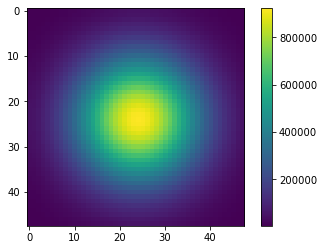

In [197]:


modes2_out = reflect(modes2_in, rmat2, fmatin = fmat2, fmatout = fmat2, gvecout = gain2)
modes1_out = reflect(modes1_in, rmat1, fmatin = fmat1, fmatout = fmat1, gvecout = gain1) 


field2_out = modes2field(mode_mask2, modes2_out)
field1_out = modes2field(mode_mask1, modes1_out)

field2_in = modes2field(mode_mask2, modes2_in)
field1_in = modes2field(mode_mask1, project(modes1_in, fmat1, None,mode = +1))
field1_in_ref = modes2field(mode_mask1, project(modes1_in, fmat1, None,mode = -1))

plt.imshow(field2poynting(field1_out)[0,0]/Z0)
plt.colorbar()
#transfer_mat(K02 * DPIXEL /2, epsilon_nl  ,angles[i], BETA, PHI)

3.407869949046521e-14


1.6169159804398257e-07

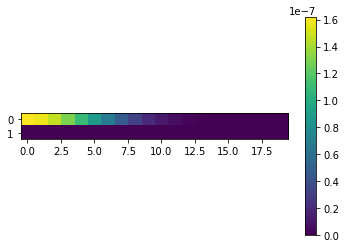

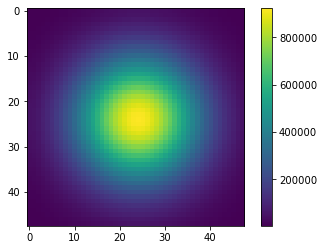

In [198]:
pfact = (WINDOW*WINDOW).sum()


i1_in_ref = field2poynting(field1_in_ref).sum(axis = (-1,-2))/Z0
i1_in = field2poynting(field1_in).sum(axis = (-1,-2))/Z0

i1_out = field2poynting(field1_out).sum(axis = (-1,-2))/Z0
i2_in = field2poynting(field2_in).sum(axis = (-1,-2))/Z0
i2_out = field2poynting(field2_out).sum(axis = (-1,-2))/Z0

total = i1_out -i1_in_ref + i2_out - i2_in

loss = i1_in - i1_out + i1_in_ref - i2_out + i2_in
print((loss/i1_in).std())

plt.imshow(i2_out/pfact)
plt.colorbar()
plt.figure()
plt.imshow(field2poynting(field1_out)[0,0]/Z0)
plt.colorbar()


field2poynting(field2_out)[0,0].sum()/pfact/Z0

In [6]:
set_analysis_mode('image')

print(f'Initializing for "{MODE}" mode.')
    
if MODE == 'wavelength':
    
    jones = np.asarray(POLARIZATIONS)[:,None,:] 
    intensities = np.asarray(INTENSITIES)[None,:]
    
    f01 = field_mat(EPSILON0[None,:], ANGLES0[None,:], BETA, PHI)
    f02 = field_mat(EPSILON0[None,:], ANGLES0[None,:], BETA, PHI)
        
    # Jones vector representation of the fundamental input beam in unitless amplitude notation.
    ampl = np.zeros((len(POLARIZATIONS),len(WAVELENGTHS), 4), dtype = CDTYPE)
    ampl[...] = avec(jones, amplitude = (intensities*Z0)**0.5)

    # epsilon tensors of fundamental and shg waves
    # we use numpy broadcasting rules here, so we add two empty axes  to match the angles array shape
    epsilon1 = np.zeros((SHAPE[0],len(WAVELENGTHS),6))
    epsilon1[...,0] = n1(WAVELENGTHS)**2
    epsilon1[...,1] = n2(WAVELENGTHS)**2
    epsilon1[...,2] = n3(WAVELENGTHS)**2
    
    epsilon2 = np.zeros((SHAPE[0],len(WAVELENGTHS),6))
    epsilon2[...,0] = n1(WAVELENGTHS/2)**2
    epsilon2[...,1] = n2(WAVELENGTHS/2)**2
    epsilon2[...,2] = n3(WAVELENGTHS/2)**2
    
    angles = np.ones((SHAPE[0],1,3)) 
    angles[:,0] = ANGLES[:,I,J]
    
    # normalized layer thickness of fundamental and shg waves
    kds1 = np.array((K01S,)* SHAPE[0])
    kds2 = np.array((K02S,)* SHAPE[0])

    E = np.empty((len(POLARIZATIONS),len(WAVELENGTHS),3), dtype = CDTYPE)


elif MODE == 'image':

    jones = np.asarray(POLARIZATIONS) 
    jones = jones[:,None,None,:] #add dummy axes for broadcasting
    
    f01 = field_mat(EPSILON0[None,None,:], ANGLES0[None,None,:],BETA, PHI)
    f02 = field_mat(EPSILON0[None,None,:], ANGLES0[None,None,:], BETA, PHI)
        
    # Jones vector representation of the fundamental input beam in unitless amplitude notation.
    ampl = np.zeros((len(POLARIZATIONS),SHAPE[1],SHAPE[2], 4), dtype = CDTYPE)
    ampl[...,0] = jones[...,0] * (INTENSITY*Z0)**0.5
    ampl[...,2] = jones[...,1] * (INTENSITY*Z0)**0.5
    
    
    # epsilon tensors of fundamental and shg waves
    # we use numpy broadcasting rules here, so we add two empty axes  to match the angles array shape
    epsilon1 = np.zeros((SHAPE[0],1,1,6))
    epsilon1[...,0] = n1(WAVELENGTH)**2
    epsilon1[...,1] = n2(WAVELENGTH)**2
    epsilon1[...,2] = n3(WAVELENGTH)**2
    
    epsilon2 = np.zeros((SHAPE[0],1,1,6))
    epsilon2[...,0] = n1(WAVELENGTH/2)**2
    epsilon2[...,1] = n2(WAVELENGTH/2)**2
    epsilon2[...,2] = n3(WAVELENGTH/2)**2
    
    # normalized layer thickness of fundamental and shg waves
    kds1 = np.array((K01,)* SHAPE[0])[:,None,None]
    kds2 = np.array((K02,)* SHAPE[0])[:,None,None]

    angles = ANGLES

    intensities = INTENSITY

    
    E = np.empty((len(POLARIZATIONS),SHAPE[1],SHAPE[2],3), dtype = CDTYPE)


elif MODE == 'full':
    jones = np.asarray(POLARIZATIONS) #must be a normalized jones vector! 
    jones = jones[:,None,None,None,:] #add dummy axes for broadcasting
    
    f01 = field_mat(EPSILON0[None,None,None,None,:], ANGLES0[None,None,None,None,:], BETA, PHI)
    f02 = field_mat(EPSILON0[None,None,None,None,:], ANGLES0[None,None,None,None,:],BETA, PHI)
    
    intensities = np.asarray(INTENSITIES)[None,:,None,None]

    
    # Jones vector representation of the fundamental input beam in unitless amplitude notation.
    ampl = np.zeros((len(POLARIZATIONS),len(WAVELENGTHS), SHAPE[1],SHAPE[2], 4), dtype = CDTYPE)
    ampl[...,0] = jones[...,0] * (intensities*Z0)**0.5
    ampl[...,2] = jones[...,1] * (intensities*Z0)**0.5
    
    # epsilon tensors of fundamental and shg waves
    # we use numpy broadcasting rules here, so we add two empty axes  to match the angles array shape
    epsilon1 = np.zeros((SHAPE[0],1,1,1,6))
    epsilon1[...,0] = n1(WAVELENGTH)**2
    epsilon1[...,1] = n2(WAVELENGTH)**2
    epsilon1[...,2] = n3(WAVELENGTH)**2
    
    epsilon2 = np.zeros((SHAPE[0],1,1,6))
    epsilon2[...,0] = n1(WAVELENGTH/2)**2
    epsilon2[...,1] = n2(WAVELENGTH/2)**2
    epsilon2[...,2] = n3(WAVELENGTH/2)**2
    
    # normalized layer thickness of fundamental and shg waves
    kds1 = np.array((K01S,)* SHAPE[0])[:,None,:,None,None]
    kds2 = np.array((K02S,)* SHAPE[0])[:,None,:,None,None]

    angles = ANGLES

    E = np.empty((len(POLARIZATIONS),len(WAVELENGTHS),SHAPE[1],SHAPE[2],3), dtype = CDTYPE)


else:
    raise ValueError(f'Unknown mode {MODE}')
print("Done!")

Initializing for "image" mode.
Done!


## Fundamental wave

First, one has to compute the fundamental mode. We use the 4x4 matrix formalism to build the matrices, compute the total transfer matrix, the reflection matrices and the output field. The computed ouptut field serves as an input for the SHG calculation step. Pay attention to the 'Intensity relative loss standard deviation' calculated at the end, which should be a really small number. It is a measure of energy conservation violation. In nonabsorbing samples it should be close to zero. 

In [7]:
print('Building layer matrices of the fundamental wave')
# we propagate forward and only half step so that we can access mid-plane 
#matrices1 = [layer_mat(-kds1[i]/2, epsilon1[i],angles[i], BETA,PHI) for i in range(SHAPE[0])]
matrices1 = [transfer_mat(kds1[i]/2, epsilon1[i],angles[i], BETA,PHI) for i in range(SHAPE[0])]
print("Building HzEz matrices")
hzez1 = hzez_mat(epsilon1, angles, BETA, PHI)
print('Building layer matrices of the shg wave')
#matrices2 = [layer_mat(-kds2[i]/2, epsilon2[i],angles[i], BETA,PHI) for i in range(SHAPE[0])]
matrices2 = [transfer_mat(kds2[i]/2, epsilon2[i],angles[i], BETA,PHI) for i in range(SHAPE[0])]
print('Calculating stack matrices')
# we apply each matrix twice because these are half-layer matrices
stack_matrix1 = multi_dot((dotmm(m,m) for m in reversed(matrices1)))
stack_matrix2 = multi_dot((dotmm(m,m)  for m in reversed(matrices2)))
print('Calculating system matrices')
smat1 = system_mat(stack_matrix1, f01,f01, transfer = "forward")
smat2 = system_mat(stack_matrix2, f02,f02, transfer = "forward")
print('Calculating reflection matrices')
rmat1 = reflection_mat(smat1,transfer = 'forward')
rmat2 = reflection_mat(smat2,transfer = 'forward')

print('Transferring fundamental field')
# convert from amplitude coefficients to EH field vector
field1_in = avec2fvec(ampl,f01)
field2_in = np.zeros_like(field1_in)

# compute output field, also modifies the input field to add reflected part
field1_out = reflect(field1_in, rmat1,fmatin = f01, fmatout = f01)
field2_out = reflect(field2_in, rmat2,fmatin = f02, fmatout = f02)

# convert to amplitude coefficients
ampl1_in = fvec2avec(field1_in,f01)
ampl1_out = fvec2avec(field1_out,f01)

# reflected field intensity
intensity1r = np.abs(ampl1_in[...,1])**2 + np.abs(ampl1_in[...,3])**2
intensity1r/=Z0

# transmitted field intensity
intensity1t = np.abs(ampl1_out[...,0])**2 + np.abs(ampl1_out[...,2])**2
intensity1t/=Z0

# this should be zero except for a small numerical error.
loss = (intensity1t+intensity1r - intensities)/intensities

#plt.imshow(loss[0,0], origin = 'lower',cmap = 'gray')#, vmin = 0, vmax = INTENSITY)
#plt.title('Total intensity relative loss')
#plt.colorbar()
print('Done!')
print()
print('Intensity relative loss standard deviation', loss.std())

Building layer matrices of the fundamental wave
Building HzEz matrices
Building layer matrices of the shg wave
Calculating stack matrices
Calculating system matrices
Calculating reflection matrices
Transferring fundamental field
Done!

Intensity relative loss standard deviation 5.086202192090225e-14


## SHG wave 

Once the fundamental field was calculated, you can run the SHG calculation step. It takes the ouptut field and propagates it back through the sample, creating SHG field. If depletion of the fundamental beam is not weak one should perform multiple SHG compuation steps. Each time we run this, we start with the fields computed from the previous run. 

In [8]:
NRUNS = 2

for run in range(NRUNS):
    print(f'Computing SHG field (run {run+1}/{NRUNS})...')
    
    field1 = field1_in.copy()
    field2 = field2_in.copy()
    
    field2_res = field2_in.copy()
    
    gain1 = np.zeros_like(field1)
    gain2 = np.zeros_like(field2)
    

    for p,i in enumerate(reversed(range(SHAPE[0]))):
        print_progress(p,SHAPE[0])

        lmat2_ref = matrices2[i]
        lmat1_ref = matrices1[i]

        # propagate both fields to mid plane
        field1h = dotmv(lmat1_ref,field1)
        field2h = dotmv(lmat2_ref,field2)
        
        field6h = hevec(field1h, hzez1[i])
        E = tmm.Evec(field6h)

        #field1h+=field2h
        
        # obtain E vector
        #E[...,0] = field1h[...,0]
        #E[...,1] = field1h[...,1]
        #EH = tmm.EHz(field1h,BETA,PHI, epsilon1[i], angles[i])   
        #E[...,2] = EH[...,0]

        #obtain rotation matrix 
        r = rotation_matrix(angles[i])
        rT = np.swapaxes(r,-1,-2) #transpose
        # rotate field to eigenframe        
        E = rotate_vector(rT, E)
        
        # compute nl susceptibility tensor
        chi2_eff = matrix2tensor(dotchi2v(CHI2,E))

        # add perturbation to epsilon tensor of the SH wavlength
        epsilon_nl = epsilon2[i] + chi2_eff/2 
        #epsilon_nl = epsilon1[i] + chi2_eff 
        # compute perturbed layer matrix
    
        lmat2 = transfer_mat(kds2[i]/2, epsilon_nl  ,angles[i])
        
        #lmat2 = dotmm(lmat2b,lmat2)
        
        #lmat2 = layer_mat(-kds1[i]/2, epsilon_nl  ,angles[i])

        # propagate reference field and perturbed fields
        field_ref2 = dotmv(lmat2_ref, field1h)
        #field_ref2 = field1h
        
        #field_ref2 = dotmv(lmat1_ref, field1h)
        field_nlo2 = dotmv(lmat2, field1h)

        # difference is the excited SHG field. Times 2 
        dif2 = (field_nlo2 - field_ref2)*2
        #dif2 = dotmv(lmat2_ref, dif2)
        
        
        chi2_eff = matrix2tensor(dotchi2v(CHI2,E.conj()))
    
        epsilon_nl = epsilon1[i] +  chi2_eff 
        

    
        lmat1 = transfer_mat(kds1[i]/2, epsilon_nl  ,angles[i])
        #lmat1 = layer_mat(-kds2[i]/2, epsilon_nl  ,angles[i])
        #lmat1s = layer_mat(kds1[i]/2, epsilon1[i]  ,angles[i])         
        field_ref1 = dotmv(lmat1_ref, field2h)
        #field_ref1 = dotmv(lmat2_ref, field2h)
        field_nlo1 = dotmv(lmat1, field2h)
        
        dif1 = (field_nlo1 - field_ref1)*2

        #dif2 = dotmv(lmat2_ref, dif2)
        #dif1 = dotmv(lmat1_ref, dif1)

        #dif1 = dif1.conj()
        lmat2_ref = dotmm(lmat2_ref,lmat2_ref)
        lmat1_ref = dotmm(lmat1_ref,lmat1_ref)
        
        gain1 = dotmv(lmat1_ref, gain1)
        gain2 = dotmv(lmat2_ref, gain2)
        
        field1 = dotmv(lmat1_ref, field1)
        field2 = dotmv(lmat2_ref, field2)
        
        field2_res = dotmv(lmat2_ref, field2_res)
    
        gain1 += dif1
        field1 += dif1
        
        gain2 += dif2
        field2 += dif2
        
    print_progress(SHAPE[0],SHAPE[0])
    

 
    amplg1= fvec2avec(gain1,f01)
    amplg2 = fvec2avec(gain2,f01)
    

    field2_out = reflect(field2_in, rmat2, fmatin = f02, fmatout = f02, gvecout = gain2)
    field1_out = reflect(field1_in, rmat1, fmatin = f01, fmatout = f01, gvecout = gain1)   
    
    ampl1_in = fvec2avec(field1_in,f01)
    ampl1_out = fvec2avec(field1_out,f01)


    intensity1r = np.abs(ampl1_in[...,1])**2 + np.abs(ampl1_in[...,3])**2
    intensity1r/=Z0
    intensity1t = np.abs(ampl1_out[...,0])**2 + np.abs(ampl1_out[...,2])**2
    intensity1t/=Z0
    
    ampl2_in = fvec2avec(field2_in,f02)
    ampl2_out = fvec2avec(field2_out,f02)

    residual_gain1_power = (np.abs(amplg1 - ampl1_out)**2).sum(axis=-1)
    residual_gain2_power = (np.abs(amplg2 - ampl2_out)**2).sum(axis=-1)
    
    #print("relative residual gain1",((residual_gain1_power/intensities).mean()))
    #print("relative residual gain2",((residual_gain2_power/intensities).mean()))
    print("field2 diff", (np.abs(field2_out-gain2-field2_res)**2).std())
    
    
    
    intensity2r = np.abs(ampl2_in[...,1])**2 + np.abs(ampl2_in[...,3])**2
    intensity2r/=Z0
    intensity2t = np.abs(ampl2_out[...,0])**2 + np.abs(ampl2_out[...,2])**2
    intensity2t/=Z0
    
    total_intensity = intensity1t+intensity1r+intensity2t+intensity2r

    loss = (total_intensity - intensities)/intensities
    print('Intensity relative loss std', loss.std())

#plt.imshow(total_intensity[0,0], origin = 'lower',cmap = 'gray')#, vmin = 0, vmax = INTENSITY)
#plt.title('Total intensity It1+It2+Ir1+Ir2')
#plt.colorbar()
print('Done!')

Computing SHG field (run 1/2)...
 |==================================================| 100.0% 
field2 diff 6.890984206213517e-08
Intensity relative loss std 5.0825830854830026e-14
Computing SHG field (run 2/2)...
 |==================================================| 100.0% 
field2 diff 2.4141554141136025e-21
Intensity relative loss std 5.081735637759557e-14
Done!


## Image analysis

### Wave intensity

In [19]:
pdb

Automatic pdb calling has been turned OFF


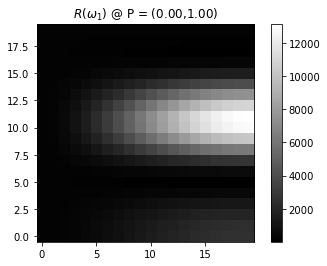

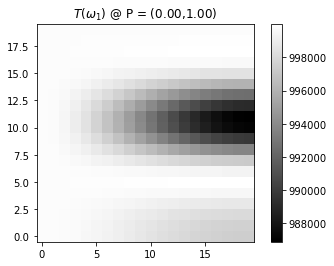

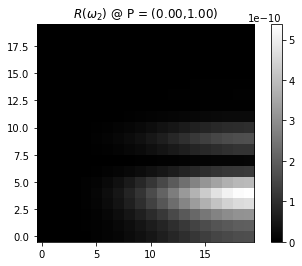

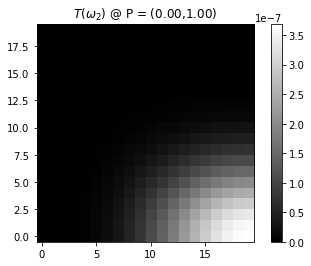

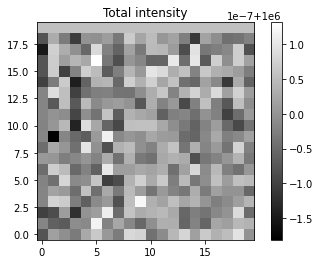

In [10]:
if MODE != 'image':
    1/0
    
PINDEX = 1

polname = polstr(POLARIZATIONS[PINDEX])
extent = []

plt.imshow(intensity1r[PINDEX], label = 'R', origin = 'lower',cmap = 'gray')
plt.title(f'$R(\omega_1)$ @ P = {polname}')
plt.colorbar()
plt.figure()
plt.imshow(intensity1t[PINDEX], label = 'T', origin = 'lower',cmap = 'gray')
plt.title(f'$T(\omega_1)$ @ P = {polname}')
plt.colorbar()
plt.figure()
plt.imshow(intensity2r[PINDEX], label = 'R', origin = 'lower',cmap = 'gray')
plt.title(f'$R(\omega_2)$ @ P = {polname}')
plt.colorbar()
plt.figure()
plt.imshow(intensity2t[PINDEX], label = 'T', origin = 'lower',cmap = 'gray')
plt.title(f'$T(\omega_2)$ @ P = {polname}')
plt.colorbar()
plt.figure()
plt.imshow(total_intensity[PINDEX], origin = 'lower',cmap = 'gray')
plt.title('Total intensity')
plt.colorbar()
    

## Wavelength analysis

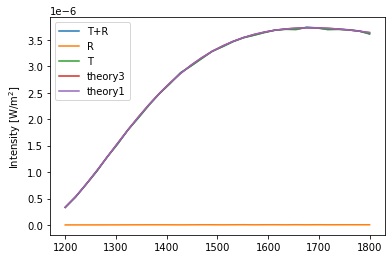

In [39]:
if MODE != 'wavelength':
    1/0
    
PINDEX = 0
def theory1(wavelength, intensity):
    new = ne(wavelength)
    ne2w = ne(wavelength/2)+0.000000001
    lamb = wavelength * 1e-9
    
    deltak = 4 * np.pi * (ne2w- new)/lamb 
    c = 3e8
    eps0 = 8.85e-12

    return intensity**2 *32* np.pi**2 * D33**2 / lamb**2 / c/eps0/new**2/ne2w *np.sin(deltak * THICKNESS/2*1e-6)**2/(deltak**2)

def theory2(wavelength, intensity):
    new = ne(wavelength)
    ne2w = ne(wavelength/2) 
    lamb = wavelength * 1e-9
    L = THICKNESS *1e-6
    k = 2*np.pi/ lamb
    
    deltakl = k* (ne2w- new)* L
    c = 3e8
    eps0 = 8.85e-12

    Ew2 = 2*intensity/c/eps0/new

    E2w = Ew2**0.5*np.tanh(k*L*D33* Ew2**0.5/ne2w)

    return 0.5*eps0*c*ne2w * E2w**2

import scipy.special 

def theory3(wavelength, intensity):
    """SHG  intensity, general analytical expression with depletion"""
    new = ne(wavelength)
    now = no(wavelength)
    ne2w = ne(wavelength/2) #+ 0.000000001
    no2w = no(wavelength/2) #+ 0.000000001
    
    lamb = wavelength * 1e-9
    L = THICKNESS *1e-6
    k = 2*np.pi/ lamb
    
    deltak = k* (ne2w - new)*2
    c = 3e8
    eps0 = 8.85e-12

    #fact = (eps0*c*ne2w/2/intensity)**0.5 *new*lamb/4/D33
    fact = (eps0*c*ne2w/2/intensity)**0.5 *new*lamb/D33/np.pi/2


    deltar = fact *deltak

    

    c = deltar/2*(1+(deltar**2)/16)**0.5
 
    # case low depletion... using taylor expension for a
    a =  2/deltar
    mask = a > 0.001
    
    # case meaningful depletion, analytic expression for a
    a[mask] = (1+(deltar[mask]**2)/8-c[mask])**0.5
        
    b = (1+(deltar**2)/8+c)**0.5



    u = b/fact*L
    m = a/b
    sn,_,_,_ = scipy.special.ellipj(u, a/b)

    return intensity * a**2* sn**2



plt.plot((WAVELENGTHS), intensity2t[PINDEX]+intensity2r[PINDEX], label = 'T+R')
plt.plot((WAVELENGTHS), intensity2r[PINDEX], label = 'R')
plt.plot((WAVELENGTHS), intensity2t[PINDEX], label = 'T')
plt.plot(WAVELENGTHS, theory3(WAVELENGTHS,INTENSITY).real, label = 'theory3')
plt.plot(WAVELENGTHS, theory1(WAVELENGTHS,INTENSITY), label = 'theory1')
plt.plot()


plt.ylabel('Intensity [W/m$^2$]')
plt.legend()

In [ ]:
if MODE != 'full':
    1/0
    
PINDEX = 0
plt.imshow(intensity2r[PINDEX,0], label = 'R', origin = 'lower',cmap = 'gray')
plt.colorbar()
plt.figure()
plt.imshow(intensity2t[PINDEX,0], label = 'T', origin = 'lower',cmap = 'gray')
plt.colorbar()
plt.figure()
plt.imshow(intensity2t[PINDEX,0]+intensity2r[PINDEX,0], origin = 'lower',cmap = 'gray')
plt.colorbar()

5.600000000000001e-06

In [409]:
scipy.special.ellipj(1, 0.9)[0]

0.7700857249078807

In [408]:
np.tanh(1)

0.7615941559557649

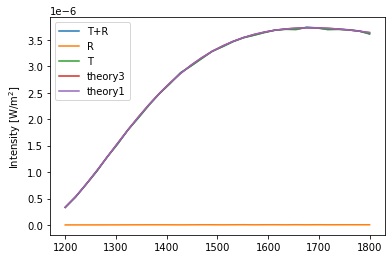

In [74]:
if MODE != 'wavelength':
    1/0
    
PINDEX = 0
def theory1(wavelength, intensity):
    new = ne(wavelength)
    ne2w = ne(wavelength/2)+0.000000001
    lamb = wavelength * 1e-9
    
    deltak = 4 * np.pi * (ne2w- new)/lamb 
    c = 3e8
    eps0 = 8.85e-12

    return intensity**2 *32* np.pi**2 * D33**2 / lamb**2 / c/eps0/new**2/ne2w *np.sin(deltak * THICKNESS/2*1e-6)**2/(deltak**2)

def theory2(wavelength, intensity):
    new = ne(wavelength)
    ne2w = ne(wavelength/2) 
    lamb = wavelength * 1e-9
    L = THICKNESS *1e-6
    k = 2*np.pi/ lamb
    
    deltakl = k* (ne2w- new)* L
    c = 3e8
    eps0 = 8.85e-12

    Ew2 = 2*intensity/c/eps0/new

    E2w = Ew2**0.5*np.tanh(k*L*D33* Ew2**0.5/ne2w)

    return 0.5*eps0*c*ne2w * E2w**2

import scipy.special 

def theory3(wavelength, intensity):
    """SHG  intensity, general analytical expression with depletion"""
    new = ne(wavelength)
    now = no(wavelength)
    ne2w = ne(wavelength/2) #+ 0.000000001
    no2w = no(wavelength/2) #+ 0.000000001
    
    lamb = wavelength * 1e-9
    L = THICKNESS *1e-6
    k = 2*np.pi/ lamb
    
    deltak = k* (ne2w - new)*2
    c = 3e8
    eps0 = 8.85e-12

    fact = (eps0*c*ne2w/2/intensity)**0.5 *new*lamb/4/D33
    fact = (eps0*c*ne2w/2/intensity)**0.5 *new*lamb/D33/2/np.pi


    deltar = fact *deltak

    

    c = deltar/2*(1+(deltar**2)/16)**0.5
 
    # case low depletion... using taylor expension for a
    a =  2/deltar
    mask = a > 0.00001
    
    # case meaningful depletion, analytic expression for a
    a[mask] = (1+(deltar[mask]**2)/8-c[mask])**0.5
        
    b = (1+(deltar**2)/8+c)**0.5



    u = b/fact*L
    m = a/b
    sn,_,_,_ = scipy.special.ellipj(u, a/b)

    return intensity * a**2* sn**2



plt.plot((WAVELENGTHS), intensity2t[PINDEX]+intensity2r[PINDEX], label = 'T+R')
plt.plot((WAVELENGTHS), intensity2r[PINDEX], label = 'R')
plt.plot((WAVELENGTHS), intensity2t[PINDEX], label = 'T')
plt.plot(WAVELENGTHS, theory3(WAVELENGTHS,INTENSITY).real, label = 'theory3')
plt.plot(WAVELENGTHS, theory1(WAVELENGTHS,INTENSITY), label = 'theory1')
plt.plot()

plt.ylabel('Intensity [W/m$^2$]')
plt.legend()

In [29]:
import dtmm2.tmm
dtmm2.tmm.alphaf(0,0,(1,0.000001,0.0000001,0.00000001))

(array([ 1.   +0.j, -1.   +0.j,  0.001+0.j, -0.001+0.j]),
 array([[ 7.07106781e-01+0.j,  7.07106781e-01+0.j, -0.00000000e+00+0.j,
          0.00000000e+00+0.j],
        [ 7.07106781e-01+0.j, -7.07106781e-01+0.j, -0.00000000e+00+0.j,
          0.00000000e+00+0.j],
        [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  9.99999500e-01+0.j,
          9.99999500e-01+0.j],
        [ 0.00000000e+00+0.j,  0.00000000e+00+0.j, -9.99999500e-04+0.j,
          9.99999500e-04+0.j]]))

In [1]:
import dtmm2.tmm

In [29]:
np.allclose(layer_mat(-1,(1,2,3),(1,2,3)),berreman_mat(1,(1,2,3),(1,2,3)) )

True

In [35]:
np.allclose(matrices1[5], matrices1a[5])

True

In [11]:
E1.shape

(1, 30, 6)

In [12]:
E.shape

(2, 30, 3)

In [27]:
field1h[...,2]-E1[...,1]

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [18]:
HzEz1[0].shape

(30, 2, 4)

In [20]:
dotmv(HzEz1[0],field1h)

array([[[ 0.00000000e+00+0.00000000e+00j,
         -3.62136092e-13-4.19237703e-14j],
        [ 0.00000000e+00+0.00000000e+00j,
         -3.55827107e-13-3.81336240e-14j],
        [ 0.00000000e+00+0.00000000e+00j,
         -3.62389313e-13-4.12845713e-14j],
        [ 0.00000000e+00+0.00000000e+00j,
         -3.57144539e-13-3.56088055e-14j],
        [ 0.00000000e+00+0.00000000e+00j,
         -3.61144998e-13-4.14790440e-14j],
        [ 0.00000000e+00+0.00000000e+00j,
         -3.60342041e-13-3.34219809e-14j],
        [ 0.00000000e+00+0.00000000e+00j,
         -3.57992549e-13-3.99493990e-14j],
        [ 0.00000000e+00+0.00000000e+00j,
         -3.64140668e-13-3.47610223e-14j],
        [ 0.00000000e+00+0.00000000e+00j,
         -3.56803316e-13-3.43413055e-14j],
        [ 0.00000000e+00+0.00000000e+00j,
         -3.62686205e-13-3.86726372e-14j],
        [ 0.00000000e+00+0.00000000e+00j,
         -3.62328571e-13-3.07349744e-14j],
        [ 0.00000000e+00+0.00000000e+00j,
         -3.57219707e-1

In [21]:
HEvec(HzEz1[i], field1h)

ValueError: dotmv: Output operand 0 has a mismatch in its core dimension 0, with gufunc signature (n,m),(m)->(n) (size 2 is different from 30)

In [14]:
timeit fvec2HEvec(field1h, epsilon1[i], angles[i], BETA, PHI)

69.7 µs ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
timeit HEvec(field1h, HzEz1[0])

28.2 µs ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
matrices1[0]

array([[[0.99370494+0.j        , 0.        +0.06531245j,
         0.        +0.j        , 0.        +0.j        ],
        [0.        +0.19216085j, 0.99370494+0.j        ,
         0.        +0.j        , 0.        +0.j        ],
        [0.        +0.j        , 0.        +0.j        ,
         0.99508622+0.j        , 0.        -0.06534261j],
        [0.        +0.j        , 0.        +0.j        ,
         0.        -0.15003099j, 0.99508622+0.j        ]],

       [[0.99391994+0.j        , 0.        +0.06421008j,
         0.        +0.j        , 0.        +0.j        ],
        [0.        +0.18880437j, 0.99391994+0.j        ,
         0.        +0.j        , 0.        +0.j        ],
        [0.        +0.j        , 0.        +0.j        ,
         0.99525446+0.j        , 0.        -0.06423872j],
        [0.        +0.j        , 0.        +0.j        ,
         0.        -0.14739643j, 0.99525446+0.j        ]],

       [[0.99412407+0.j        , 0.        +0.06314422j,
         0.        

In [160]:
eigenmask(BEAM_SHAPE, K01_PIXEL/10, aspect = PIXEL_ASPECT, betamax = 1).sum()

5

In [196]:
from dtmm2.tmm import field_eig
alpha,f = field_eig((1,1,1),(0,0,0),0.5,np.pi/4, normalize = True)
alpha0,f0 = field_eig((1,1,1),(0,0,0),0.,np.pi/4, normalize = True)

In [199]:
f0

array([[ 0.70710678+0.j,  0.70710678+0.j, -0.70710678+0.j,
        -0.70710678+0.j],
       [ 0.70710678+0.j, -0.70710678+0.j, -0.70710678+0.j,
         0.70710678+0.j],
       [ 0.70710678+0.j,  0.70710678+0.j,  0.70710678+0.j,
         0.70710678+0.j],
       [-0.70710678+0.j,  0.70710678+0.j, -0.70710678-0.j,
         0.70710678+0.j]])

In [157]:
(WINDOW*WINDOW).sum()

36.19114736935442